2022-10-02 22:13:17.197150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-02 22:13:19.062816: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-02 22:13:19.064087: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-02 22:13:19.090583: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-02 22:13:19.090624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 68 deviceMemorySize: 10.00GiB deviceMemoryBandwidth: 707.88GiB/s
2022-10-02 22:13:19.090673: I tensorflow/stream_executor/platfo

Train: 0.840, Test: 0.813


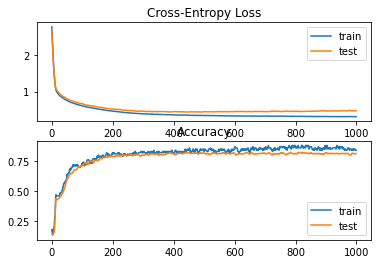

In [1]:
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

y = to_categorical(y)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=1000, verbose=0)

_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [2]:
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from os import makedirs

X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

y = to_categorical(y)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

makedirs('models')

n_epochs, n_save_after = 1000, 950
for i in range(n_epochs):
	# fit model for a single epoch
	model.fit(trainX, trainy, epochs=1, verbose=0)
	# check if we should save the model
	if i >= n_save_after:
		model.save('models/model_' + str(i) + '.h5')

>loaded models/model_950.h5
>loaded models/model_951.h5
>loaded models/model_952.h5
>loaded models/model_953.h5
>loaded models/model_954.h5
>loaded models/model_955.h5
>loaded models/model_956.h5
>loaded models/model_957.h5
>loaded models/model_958.h5
>loaded models/model_959.h5
>loaded models/model_960.h5
>loaded models/model_961.h5
>loaded models/model_962.h5
>loaded models/model_963.h5
>loaded models/model_964.h5
>loaded models/model_965.h5
>loaded models/model_966.h5
>loaded models/model_967.h5
>loaded models/model_968.h5
>loaded models/model_969.h5
>loaded models/model_970.h5
>loaded models/model_971.h5
>loaded models/model_972.h5
>loaded models/model_973.h5
>loaded models/model_974.h5
>loaded models/model_975.h5
>loaded models/model_976.h5
>loaded models/model_977.h5
>loaded models/model_978.h5
>loaded models/model_979.h5
>loaded models/model_980.h5
>loaded models/model_981.h5
>loaded models/model_982.h5
>loaded models/model_983.h5
>loaded models/model_984.h5
>loaded models/model

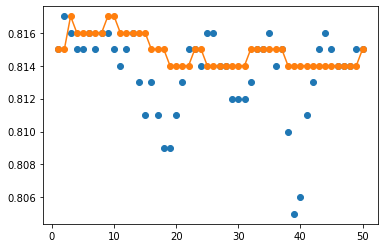

In [3]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy


def load_all_models(n_start, n_end):
	all_models = list()
	for epoch in range(n_start, n_end):
		filename = 'models/model_' + str(epoch) + '.h5'
		model = load_model(filename)
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models


def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	return result


def evaluate_n_members(members, n_members, testX, testy):
	subset = members[:n_members]
	yhat = ensemble_predictions(subset, testX)
	return accuracy_score(testy, yhat)

X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

members = load_all_models(950, 1000)
print('Loaded %d models' % len(members))

members = list(reversed(members))

single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	ensemble_score = evaluate_n_members(members, i, testX, testy)
	testy_enc = to_categorical(testy)
	_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)

print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()